In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

# Parameters

In [2]:
#TODO Test and show results on Forest Cover Dataset 
dataset='ElectricDevices'

# Load Data

In [3]:

train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [4]:
print(test_y.shape)

(7711,)


In [5]:
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


# Model Training

In [6]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

# Explanation Algo

In [7]:
item=train_x[1].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
#y_target= model(_item).detach().numpy()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [8]:
print(y_target)

[[1.0000000e+00 6.6886139e-21 2.4278204e-14 6.3224306e-17 4.5065074e-10
  2.9705713e-12 8.7912681e-16]]


In [25]:
from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import Vanilla_Autoencoder

autoencoder= Vanilla_Autoencoder(item.shape[2])
autoencoder.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_new_params'))
exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),train_loader, test_loader, autoencoder=autoencoder)

Epoch: 0, Fine Tune Loss: 4238.764
Epoch: 1, Fine Tune Loss: 929.983
Epoch: 2, Fine Tune Loss: 342.169
Epoch: 3, Fine Tune Loss: 157.816
Epoch: 4, Fine Tune Loss: 105.659
Epoch: 5, Fine Tune Loss: 136.001
Epoch: 6, Fine Tune Loss: 90.99
Epoch: 7, Fine Tune Loss: 151.652
Epoch: 8, Fine Tune Loss: 62.263
Epoch: 9, Fine Tune Loss: 64.077
Epoch: 10, Fine Tune Loss: 55.867
Epoch: 11, Fine Tune Loss: 81.829
Epoch: 12, Fine Tune Loss: 38.788
Epoch: 13, Fine Tune Loss: 42.576
Epoch: 14, Fine Tune Loss: 53.852
Epoch: 15, Fine Tune Loss: 36.528
Epoch: 16, Fine Tune Loss: 33.319
Epoch: 17, Fine Tune Loss: 40.466
Epoch: 18, Fine Tune Loss: 35.929
Epoch: 19, Fine Tune Loss: 37.185
Epoch: 20, Fine Tune Loss: 31.941
Epoch: 21, Fine Tune Loss: 40.059
Epoch: 22, Fine Tune Loss: 56.017
Epoch: 23, Fine Tune Loss: 42.707
Epoch: 24, Fine Tune Loss: 36.381
Epoch: 25, Fine Tune Loss: 36.324
Epoch: 26, Fine Tune Loss: 29.47
Epoch: 27, Fine Tune Loss: 29.543
Epoch: 28, Fine Tune Loss: 36.218
Epoch: 29, Fine Tu

In [10]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(shape[-2],shape[-1]),train_loader, test_loader)

2022-07-26 16:56:57.938539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-26 16:56:57.938556: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch: 0, Train loss: 0.961, Validation loss: 0.968
Best Model is triggered
Epoch: 1, Train loss: 0.942, Validation loss: 0.967
Best Model is triggered
Epoch: 2, Train loss: 0.99, Validation loss: 0.962
Best Model is triggered
Epoch: 3, Train loss: 0.995, Validation loss: 0.964
Epoch: 4, Train loss: 0.976, Validation loss: 0.961
Best Model is triggered
Epoch: 5, Train loss: 0.926, Validation loss: 0.964
Epoch: 6, Train loss: 0.969, Validation loss: 0.958
Best Model is triggered
Epoch: 7, Train loss: 0.985, Validation loss: 0.957
Best Model is triggered
Epoch: 8, Train loss: 0.973, Validation loss: 0.957
Best Model is triggered
Epoch: 9, Train loss: 0.948, Validation loss: 0.956
Best Model is triggered
Epoch: 10, Train loss: 0.949, Validation loss: 0.953
Best Model is triggered
Epoch: 11, Train loss: 0.977, Validation loss: 0.956
Epoch: 12, Train loss: 0.945, Validation loss: 0.949
Best Model is triggered
Epoch: 13, Train loss: 0.983, Validation loss: 0.953
Epoch: 14, Train loss: 0.944,

In [11]:
# save model 
#torch.save(exp_model.autoencoder.state_dict(), f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_new_params')

In [12]:
exp=exp_model.explain(item)

In [13]:
np.count_nonzero(item.flatten()-exp.flatten())

96

In [14]:
exp.shape

(1, 1, 96)

In [15]:
item.shape

(1, 1, 96)

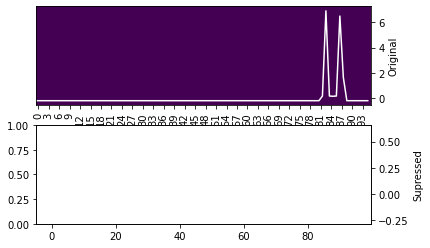

In [16]:
#TODO scale og plot
exp_model.plot(item, exp,all_in_one=False)

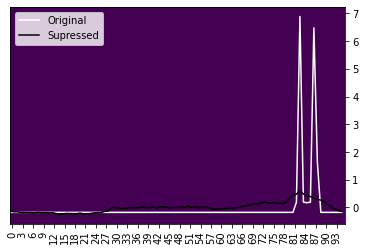

In [17]:
exp_model.plot(item, exp)

In [18]:
np.min(exp)

-0.24205697

In [19]:
np.max(exp)

0.6151295

<AxesSubplot:>

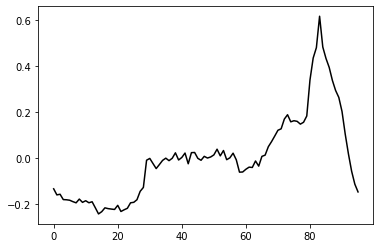

In [20]:
sns.lineplot(x=range(0,len(exp.reshape(-1))), y=exp.flatten(), color='black')

In [21]:
#print(exp)

In [22]:
#print(exp.shape)

# Plot Item 

In [23]:

#exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

In [24]:
#xp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)